In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [7]:
# Paramètres de téléchargement
tickers = ['AAPL', 'MSFT', 'JPM']
start_date = '2013-01-01'
end_date = '2023-01-01'

# Télécharger une seule fois le VIX pour la période
vix = yf.download("^VIX", start=start_date, end=end_date)

if 'Close' in vix.columns:
    scaler = StandardScaler()
    # Calculer le z-score du VIX basé sur la colonne 'Close'
    vix['VIX_Zscore'] = scaler.fit_transform(vix[['Close']])
    # On définit le MarketSentiment comme l'opposé du z-score (plus le VIX est élevé, plus le sentiment est bas)
    vix['MarketSentiment'] = -vix['VIX_Zscore']
else:
    vix['MarketSentiment'] = np.nan

# Dictionnaire pour stocker les DataFrames de chaque ticker
data = {}


# Téléchargement et Enrichissement pour chaque ticker

for ticker in tickers:
    print(f"--- Téléchargement des données pour {ticker} ---")
    df = yf.download(ticker, start=start_date, end=end_date)

    # Aplatir les colonnes si MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)

    # Calculer un ratio P/E "dynamique" avec la colonne 'Close'
    ticker_obj = yf.Ticker(ticker)
    trailing_eps = ticker_obj.info.get('trailingEps', None)  # EPS sur 12 mois glissants
    if trailing_eps is not None and trailing_eps != 0 and 'Close' in df.columns:
        df['PE_Ratio'] = df['Close'] / trailing_eps
    else:
        df['PE_Ratio'] = np.nan

    # Ajouter la colonne MarketSentiment basée sur le VIX
    # On réindexe le VIX sur les dates de df, puis on fait un ffill
    market_sentiment = vix['MarketSentiment'].reindex(df.index, method='ffill')
    df['MarketSentiment'] = market_sentiment

    data[ticker] = df

# Vérification  pour AAPL
print("\nColonnes de AAPL après enrichissement :")
print(data['AAPL'].columns)
print(data['AAPL'].head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


--- Téléchargement des données pour AAPL ---


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

--- Téléchargement des données pour MSFT ---


--- Téléchargement des données pour JPM ---


[*********************100%***********************]  1 of 1 completed



Colonnes de AAPL après enrichissement :
Index(['Close', 'High', 'Low', 'Open', 'Volume', 'PE_Ratio',
       'MarketSentiment'],
      dtype='object', name='Price')
Price           Close       High        Low       Open     Volume  PE_Ratio  \
Date                                                                          
2013-01-02  16.669008  16.850263  16.444339  16.814437  560518000  2.645874   
2013-01-03  16.458616  16.688448  16.425219  16.634102  352965200  2.612479   
2013-01-04  16.000170  16.353267  15.964647  16.302868  594333600  2.539709   
2013-01-07  15.906047  16.069994  15.641907  15.848361  484156400  2.524769   
2013-01-08  15.948852  16.148626  15.825588  16.067259  458707200  2.531564   

Price       MarketSentiment  
Date                         
2013-01-02         0.432352  
2013-01-03         0.448668  
2013-01-04         0.547919  
2013-01-07         0.553358  
2013-01-08         0.576471  


In [8]:
for ticker, df in data.items():
    print(f"--- {ticker} ---")
    
    total_rows = len(df)
    print(f"Total de lignes: {total_rows}")
    
    # Calculer et afficher le pourcentage de valeurs manquantes par colonne
    missing_percent = (df.isnull().mean() * 100).round(2)
    print("Pourcentage de valeurs manquantes par colonne:")
    print(missing_percent)
    
    # Afficher un résumé statistique de base pour les colonnes numériques
    print("Résumé statistique:")
    print(df.describe())
    
    print("\n")

--- AAPL ---
Total de lignes: 2518
Pourcentage de valeurs manquantes par colonne:
Price
Close              0.0
High               0.0
Low                0.0
Open               0.0
Volume             0.0
PE_Ratio           0.0
MarketSentiment    0.0
dtype: float64
Résumé statistique:
Price        Close         High          Low         Open        Volume  \
count  2518.000000  2518.000000  2518.000000  2518.000000  2.518000e+03   
mean     59.940108    60.587121    59.245563    59.907643  1.713540e+08   
std      48.682628    49.292023    48.027631    48.656213  1.250497e+08   
min      11.925922    12.202900    11.760101    11.847745  3.519590e+07   
25%      24.393019    24.709226    24.177069    24.456295  9.188698e+07   
50%      39.057541    39.498165    38.623879    39.009177  1.301368e+08   
75%      89.087122    90.405996    88.403342    88.839518  2.045116e+08   
max     178.879913   179.793920   176.039607   179.489254  1.460852e+09   

Price     PE_Ratio  MarketSentiment  
co

In [9]:
def compute_rsi(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(df, short=12, long=26, signal=9):
    df['EMA_short'] = df['Close'].ewm(span=short, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_MACD'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    return df

def compute_bollinger_bands(df, window=20, n_std=2):
    df['MA20'] = df['Close'].rolling(window=window).mean()
    df['STD20'] = df['Close'].rolling(window=window).std()
    df['Upper_BB'] = df['MA20'] + (n_std * df['STD20'])
    df['Lower_BB'] = df['MA20'] - (n_std * df['STD20'])
    return df

def compute_atr(df, period=14):
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=period).mean()
    df.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)
    return df


# Calcul des Indicateurs Techniques

for ticker in tickers:
    df = data[ticker].copy()

    # RSI
    df['RSI'] = compute_rsi(df)

    # MACD
    df = compute_macd(df)

    # Bollinger
    df = compute_bollinger_bands(df)

    # ATR
    df = compute_atr(df)

    # Réassigner dans le dictionnaire
    data[ticker] = df

# Vérif sur AAPL
print("\nColonnes AAPL après indicateurs :")
print(data['AAPL'].columns)
print(data['AAPL'].head())


Colonnes AAPL après indicateurs :
Index(['Close', 'High', 'Low', 'Open', 'Volume', 'PE_Ratio', 'MarketSentiment',
       'RSI', 'EMA_short', 'EMA_long', 'MACD', 'Signal_MACD', 'MA20', 'STD20',
       'Upper_BB', 'Lower_BB', 'ATR'],
      dtype='object', name='Price')
Price           Close       High        Low       Open     Volume  PE_Ratio  \
Date                                                                          
2013-01-02  16.669008  16.850263  16.444339  16.814437  560518000  2.645874   
2013-01-03  16.458616  16.688448  16.425219  16.634102  352965200  2.612479   
2013-01-04  16.000170  16.353267  15.964647  16.302868  594333600  2.539709   
2013-01-07  15.906047  16.069994  15.641907  15.848361  484156400  2.524769   
2013-01-08  15.948852  16.148626  15.825588  16.067259  458707200  2.531564   

Price       MarketSentiment  RSI  EMA_short   EMA_long      MACD  Signal_MACD  \
Date                                                                            
2013-01-02     

In [10]:
for ticker in tickers:
    df = data[ticker].copy()

    # Supprimer les NaN (début de série, indicateurs)
    df.dropna(inplace=True)

    # Target = prix de clôture du jour suivant
    df['Target'] = df['Close'].shift(-1)

    # Dernière ligne devient NaN -> supprimer
    df.dropna(inplace=True)

    data[ticker] = df

print("\nAperçu final (AAPL) :")
print(data['AAPL'].head())
print(data['AAPL'].columns)


Aperçu final (AAPL) :
Price           Close       High        Low       Open     Volume  PE_Ratio  \
Date                                                                          
2013-01-30  13.869748  14.044931  13.799008  13.874909  417155200  2.201547   
2013-01-31  13.829060  13.944127  13.813576  13.874298  319334400  2.195089   
2013-02-01  13.772288  13.950203  13.612287  13.938970  539484400  2.186078   
2013-02-04  13.429211  13.842725  13.419495  13.781092  477117200  2.131621   
2013-02-05  13.900406  13.958092  13.426169  13.481730  573347600  2.206414   

Price       MarketSentiment        RSI  EMA_short   EMA_long      MACD  \
Date                                                                     
2013-01-30         0.481298  33.092018  14.522241  15.205205 -0.682964   
2013-01-31         0.486737  30.359168  14.415598  15.103268 -0.687670   
2013-02-01         0.674363  30.595999  14.316627  15.004677 -0.688050   
2013-02-04         0.433712  31.943823  14.180101  14


MSE Régression Linéaire (AAPL) : 8.67


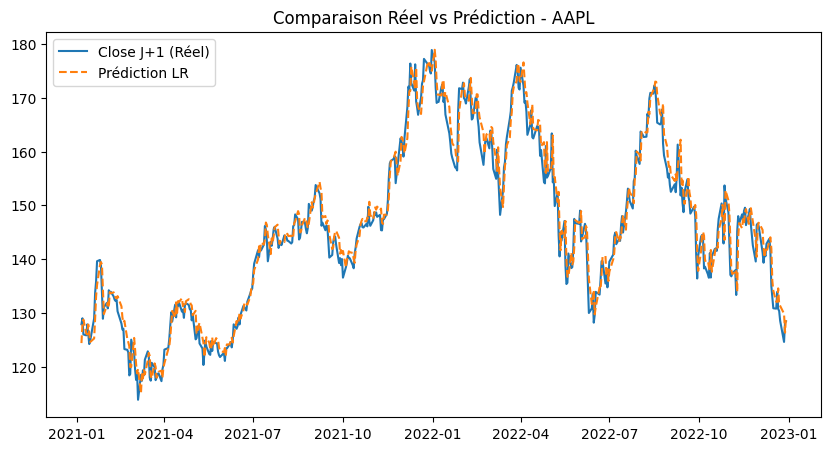

In [26]:
ticker_choice = 'AAPL'
df_model = data[ticker_choice].copy()

# Liste de features
features = [
    'Close', 'Volume', 'RSI', 'MACD', 'Signal_MACD',
    'MA20', 'Upper_BB', 'Lower_BB', 'ATR',
    'PE_Ratio', 'MarketSentiment'
]

X = df_model[features]
y = df_model['Target']

# Split Entraînement / Test (80/20) sans mélanger l'ordre
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
print(f"\nMSE Régression Linéaire ({ticker_choice}) : {mse_lr:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Close J+1 (Réel)')
plt.plot(y_test.index, y_pred, label='Prédiction LR', linestyle='--')
plt.title(f"Comparaison Réel vs Prédiction - {ticker_choice}")
plt.legend()
plt.show()

Colonnes df_model: ['Close', 'High', 'Low', 'Open', 'Volume', 'PE_Ratio', 'MarketSentiment', 'RSI', 'EMA_short', 'EMA_long', 'MACD', 'Signal_MACD', 'MA20', 'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'Target']
Train size: 1998 | Test size: 500
Forme X_train_seq: (1978, 20, 11), y_train_seq: (1978, 1)
Forme X_test_seq:  (480, 20, 11),  y_test_seq: (480, 1)


c:\Users\khali\ml-project\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0066 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.6992e-04 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.2699e-04 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.6183e-04 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.5663e-04 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.8698e-04 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 7/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.9092e-04
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.9060e-04 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.4692e-04 - val_lo

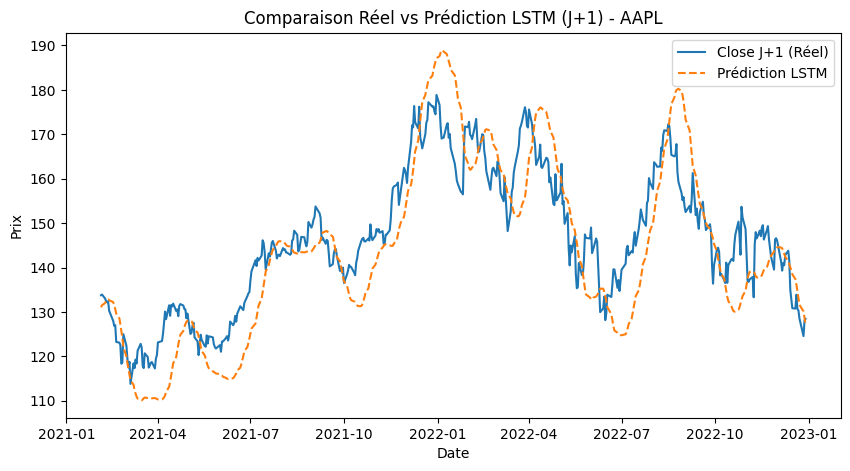

In [ ]:
import os

# Pour forcer un maximum de reproductibilité (peut ralentir l'exécution)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(42)
tf.random.set_seed(42)

#  Récupération du DataFrame

ticker_choice = 'AAPL'
df_model = data[ticker_choice].copy()

# Vérification des colonnes (dont 'Target' = Close(t+1))
print("Colonnes df_model:", df_model.columns.tolist())

# On enlève les lignes NaN (par ex. si RSI, MACD, etc. créent des trous)
df_model.dropna(inplace=True)


# 2) Définir les features et la cible

features = [
    'Close', 'Volume', 'RSI', 'MACD', 'Signal_MACD',
    'MA20', 'Upper_BB', 'Lower_BB', 'ATR',
    'PE_Ratio', 'MarketSentiment'
]
X = df_model[features].copy()
y = df_model['Target'].copy()  # 'Target' déjà défini comme Close.shift(-1)


# Split 80/20 (2013–2023) sans shuffle

# df_model doit couvrir 2013–2023 (vérifie len(df_model) > 0)
train_size = int(0.8 * len(df_model))
X_train_raw = X.iloc[:train_size]
X_test_raw  = X.iloc[train_size:]
y_train_raw = y.iloc[:train_size]
y_test_raw  = y.iloc[train_size:]

print(f"Train size: {len(X_train_raw)} | Test size: {len(X_test_raw)}")


# Scaling des features et de la cible

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled  = scaler_X.transform(X_test_raw)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.values.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test_raw.values.reshape(-1,1))


# Création des séquences LSTM

seq_length = 20

def create_sequences(X_array, y_array, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X_array)):
        # On prend une fenêtre de seq_len
        X_seq.append(X_array[i-seq_len:i, :])
        # La cible = y_array[i], c-à-d. la valeur au point i
        y_seq.append(y_array[i])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  seq_length)

print(f"Forme X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
print(f"Forme X_test_seq:  {X_test_seq.shape},  y_test_seq: {y_test_seq.shape}")

if len(X_train_seq) == 0:
    print("ERREUR: Pas assez de données pour créer des séquences d'entraînement.")
if len(X_test_seq) == 0:
    print("ERREUR: Pas assez de données pour créer des séquences de test.")


## Construction du LSTM

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks pour stopper l'entraînement si la validation stagne
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


# Entraînement

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es, rlrop],
    verbose=1
)


# Prédiction et évaluation

y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

mse_lstm = mean_squared_error(y_test_inv, y_pred)
print(f"\nMSE LSTM (J+1) ({ticker_choice}) : {mse_lstm:.2f}")


# Visualisation des prédictions

test_index = X_test_raw.index[seq_length:]  # on retire seq_length jours
plt.figure(figsize=(10,5))
plt.plot(test_index, y_test_inv, label='Close J+1 (Réel)')
plt.plot(test_index, y_pred, label='Prédiction LSTM', linestyle='--')
plt.title(f"Comparaison Réel vs Prédiction LSTM (J+1) - {ticker_choice}")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.show()


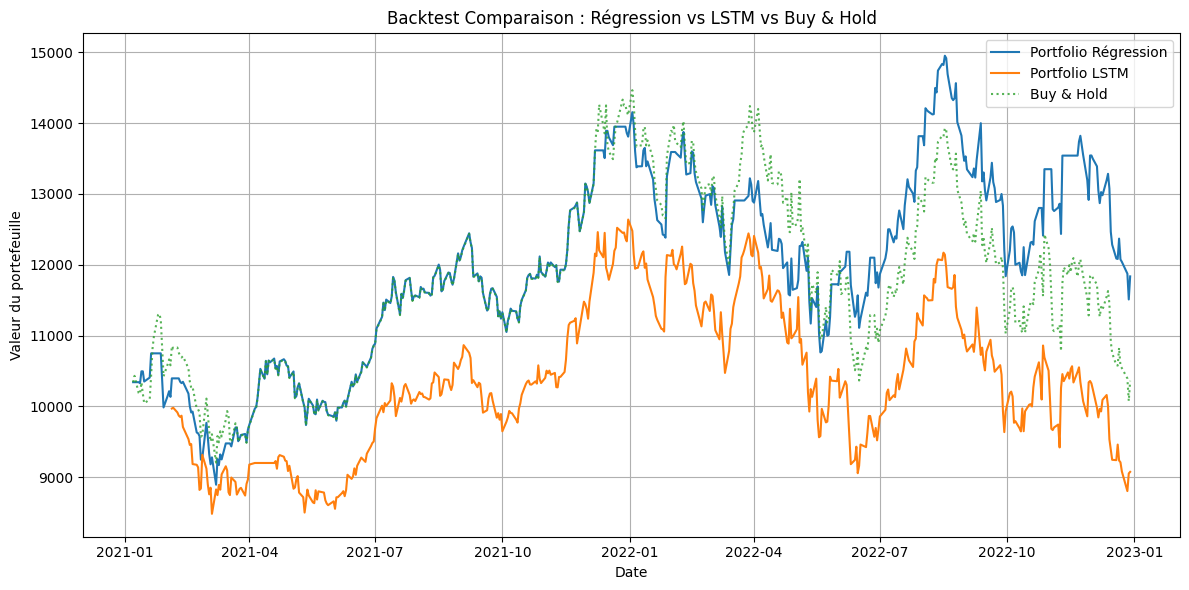

=== Performance Backtest ===
Régression Linéaire - Rendement cumulé: 18.35% | Sharpe Ratio: 0.44
LSTM               - Rendement cumulé: -9.26% | Sharpe Ratio: -0.02
Buy & Hold         - Rendement cumulé: 0.19% | Sharpe Ratio: 0.16


In [16]:

# === Fonction de backtest simplifié ===
def simple_backtest(current_close, next_close, predictions, initial_cash=10000):
    portfolio = [initial_cash]
    for i in range(len(predictions)):
        if predictions[i] > current_close[i]:
            daily_ret = next_close[i] / current_close[i]
        else:
            daily_ret = 1.0
        portfolio.append(portfolio[-1] * daily_ret)
    return np.array(portfolio)

# === Fonction de performance ===
def performance_report(portfolio):
    returns = np.diff(portfolio) / portfolio[:-1]
    cum_return = (portfolio[-1] / portfolio[0] - 1) * 100
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) != 0 else 0
    return cum_return, sharpe

# === Backtest Régression Linéaire ===
current_close_lr = X_test['Close'].values[:-1]
next_close_lr = y_test.values[:-1]
predictions_lr = y_pred_lr[:-1]
portfolio_lr = simple_backtest(current_close_lr, next_close_lr, predictions_lr)

# === Backtest LSTM ===
lstm_index = X_test_raw.index[seq_length:]
current_close_lstm = X_test_raw['Close'].values[seq_length:]
next_close_lstm = y_test_inv_lstm.flatten()
predictions_lstm = y_pred_lstm.flatten()
portfolio_lstm = simple_backtest(current_close_lstm, next_close_lstm, predictions_lstm)

# === BUY & HOLD ===
buy_hold = [10000 * (next_close_lr[i] / current_close_lr[0]) for i in range(len(next_close_lr))]
buy_hold = np.array(buy_hold)

# === Affichage des 3 portefeuilles ===
plt.figure(figsize=(12,6))
plt.plot(X_test.index[1:], portfolio_lr[1:], label="Portfolio Régression")
plt.plot(lstm_index, portfolio_lstm[1:], label="Portfolio LSTM")
plt.plot(X_test.index[1:], buy_hold, label="Buy & Hold", linestyle=':', alpha=0.8)
plt.title("Backtest Comparaison : Régression vs LSTM vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Valeur du portefeuille")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Rapport de performance ===
cum_ret_lr, sharpe_lr = performance_report(portfolio_lr)
cum_ret_lstm, sharpe_lstm = performance_report(portfolio_lstm)

# Buy & Hold
def performance_buyhold(buy_hold):
    returns = np.diff(buy_hold) / buy_hold[:-1]
    cum_return = (buy_hold[-1] / buy_hold[0] - 1) * 100
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) != 0 else 0
    return cum_return, sharpe

cum_ret_bh, sharpe_bh = performance_buyhold(buy_hold)

# === Résultats ===
print("=== Performance Backtest ===")
print(f"Régression Linéaire - Rendement cumulé: {cum_ret_lr:.2f}% | Sharpe Ratio: {sharpe_lr:.2f}")
print(f"LSTM               - Rendement cumulé: {cum_ret_lstm:.2f}% | Sharpe Ratio: {sharpe_lstm:.2f}")
print(f"Buy & Hold         - Rendement cumulé: {cum_ret_bh:.2f}% | Sharpe Ratio: {sharpe_bh:.2f}")
